In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA, FastICA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin

In [3]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    y_pred = model.predict(X_test)
    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [4]:
def plot_learning_curve(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

def plot_validation_curve(clf, X_train, y_train, param_name, cv):
    # Define the hyperparameter range
    param_range = np.arange(1, 21)

    # Calculate training and validation scores over the specified hyperparameter range
    train_scores, test_scores = validation_curve(
        clf, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1
    )

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title('Model Complexity Graph')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [5]:
from scipy.stats import boxcox

models = []
file_path = "../notebooks/Airline Passenger Satisfaction.csv"
data = pd.read_csv(file_path)

ds=data
ds["Arrival Delay in Minutes"].fillna(0, inplace=True)
ds["Flight Distance"] = boxcox(ds["Flight Distance"])[0]
ds["Arrival Delay in Minutes"] = np.sqrt(np.log1p(ds["Arrival Delay in Minutes"]))
ds["Departure Delay in Minutes"] = np.sqrt(np.log1p(ds["Departure Delay in Minutes"]))

scols = ds.select_dtypes(object).columns
for col in scols:
    ds[col] = LabelEncoder().fit_transform(ds[col])
    
y = ds["satisfaction"]
ds = pd.DataFrame(StandardScaler().fit_transform(ds.iloc[:, :-1]), columns=ds.columns[:-1])
X=ds

C:\Users\abhis\AppData\Local\Temp\ipykernel_8008\3953601028.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ds["Arrival Delay in Minutes"].fillna(0, inplace=True)


C:\Users\abhis\AppData\Local\Temp\ipykernel_8008\607836480.py:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\abhis\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


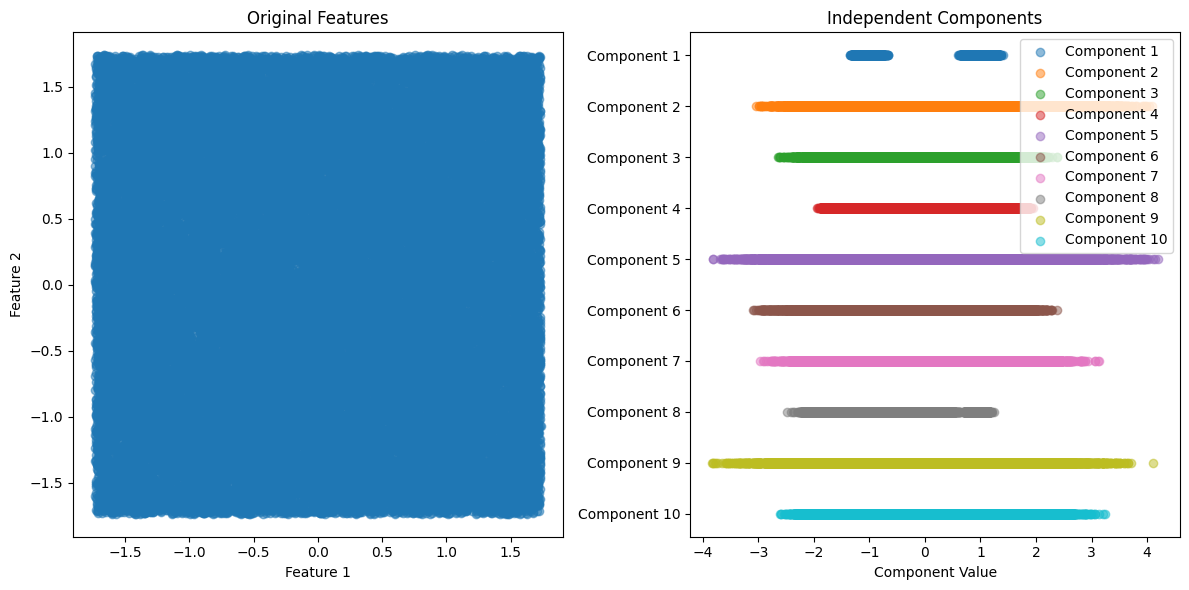

In [6]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(data)

# # Apply ICA
# ica = FastICA(n_components=10, random_state=42)  # Specify the number of components
# X_ica = ica.fit_transform(X)

# # Visualize the results
# plt.figure(figsize=(12, 6))

# # Plot the original features
# plt.subplot(1, 2, 1)
# plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5)
# plt.title('Original Features')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')

# # Plot the independent components
# plt.subplot(1, 2, 2)
# for i in range(X_ica.shape[1]):
#     plt.scatter(X_ica[:, i], np.zeros_like(X_ica[:, i]) + i, alpha=0.5)
# plt.title('Independent Components')
# plt.xlabel('Component Value')
# plt.yticks(range(X_ica.shape[1]), [f'Component {i+1}' for i in range(X_ica.shape[1])])
# plt.ylim(-1, X_ica.shape[1])
# plt.gca().invert_yaxis()

# plt.tight_layout()
# plt.show()

from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import numpy as np

def plot_ica_results(X_scaled, X_ica, n_components):
    # Create subplots for original features and independent components
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot original features
    axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5)
    axes[0].set_title('Original Features')
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    
    # Plot independent components
    for i in range(n_components):
        axes[1].scatter(X_ica[:, i], np.zeros_like(X_ica[:, i]) + i, alpha=0.5, label=f'Component {i+1}')
    axes[1].set_title('Independent Components')
    axes[1].set_xlabel('Component Value')
    axes[1].set_yticks(range(n_components))
    axes[1].set_yticklabels([f'Component {i+1}' for i in range(n_components)])
    axes[1].invert_yaxis()
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Apply ICA
ica = FastICA(n_components=10, random_state=42)  # Specify the number of components
X_ica = ica.fit_transform(X_scaled)

# Visualize the results
plot_ica_results(X_scaled, X_ica, n_components=10)


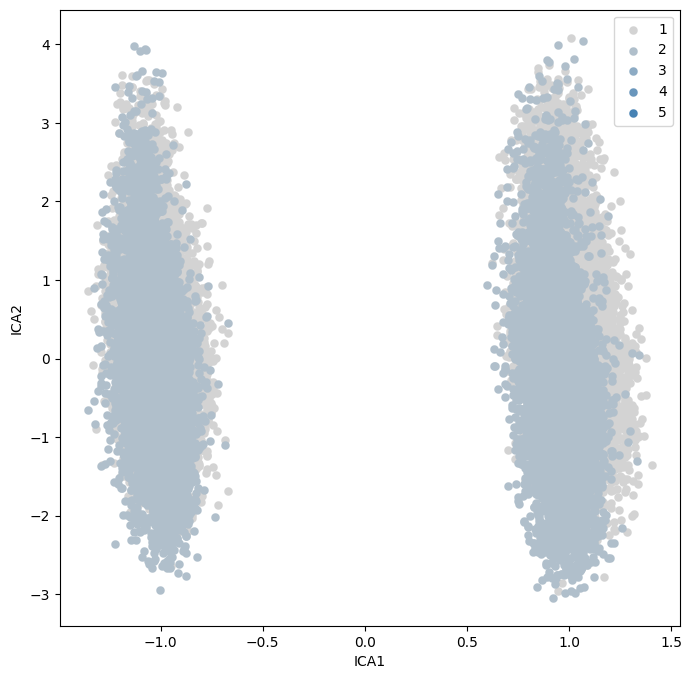

In [9]:
colors = ['#D3D3D3', '#B0BFCB', '#8DABC4', '#6996BC', '#4682B4']
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, [0,1,2,3,4], [1,2,3,4,5]):
    plt.scatter(X_ica[y == i, 0], X_ica[y == i, 1], color=color, lw=0.1, label=target_name)

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("ICA1")
plt.ylabel("ICA2")
plt.show()
from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=2, random_state=42)
# clusters = kmeans.fit_predict(X_ica)
# plt.figure(figsize=(8, 6))
# plt.scatter(X_ica[:, 0], X_ica[:, 1], c=clusters, cmap='viridis', alpha=0.5)
# plt.title('Clusters in ICA-transformed Space')
# plt.xlabel('ICA Component 1')
# plt.ylabel('ICA Component 2')
# plt.colorbar(label='Cluster')
# plt.show()

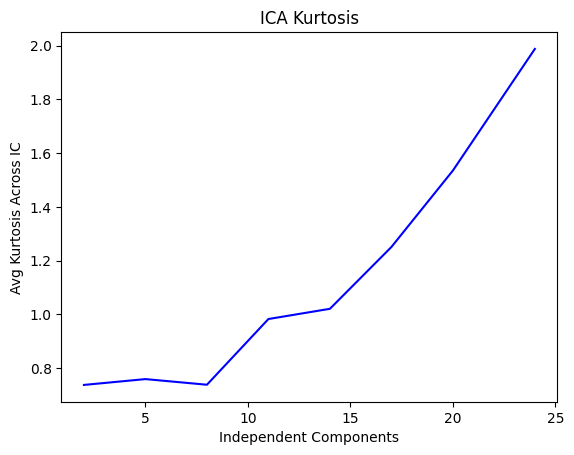

In [7]:
dims = list(np.arange(2,(X.shape[1]-1),3))
dims.append(X.shape[1])
ica = FastICA(random_state=5)
kurt = []

for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt.append(tmp.abs().mean())

plt.figure()
plt.title("ICA Kurtosis")
plt.xlabel("Independent Components")
plt.ylabel("Avg Kurtosis Across IC")
plt.plot(dims, kurt, 'b-')
plt.grid(False)
plt.show()